# Vision Fine-tuning on GPT-4o for Visual Question Answering

We're excited to announce the launch of [Vision Fine-Tuning on GPT-4o](https://openai.com/index/introducing-vision-to-the-fine-tuning-api/), a cutting-edge multimodal fine-tuning capability that empowers developers to fine-tune GPT-4o using both **images** and **text**. With this new feature, you can customize models to have stronger image understanding capabilities, unlocking possibilities across various industries and applications.

From **advanced visual search** to **improved object detection** for autonomous vehicles or smart cities, vision fine-tuning enables you to craft solutions tailored to your specific needs. By combining text and image inputs, this product is uniquely positioned for tasks like **visual question answering**, where detailed, context-aware answers are derived from analyzing images. In general, this seems to be most effective when the model is presented with questions and images that resemble the training data as we are able to teach the model how to search and identify relevant parts of the image to answer the question correctly. Similarly to fine-tuning on text inputs, vision fine-tuning is not as useful for teaching the model new information.

In this guide, we’ll walk you through the steps to fine-tune GPT-4o with multimodal inputs. Specifically, we’ll demonstrate how to train a model for answering questions related to **images of books**, but the potential applications span countless domains—from **web design** and **education** to **healthcare** and **research**.

Whether you're looking to build smarter defect detection models for manufacturing, enhance complex document processing and diagram understanding, or develop applications with better visual comprehension for a variety of other use cases, this guide will show you just how fast and easy it is to get started.

For more information, check out the full [Documentation](https://platform.openai.com/docs/guides/fine-tuning/vision).

In [1]:
from openai import OpenAI, ChatCompletion
import json
import os

client = OpenAI()

### Load Dataset

We will work with a dataset of question-answer pairs on images of books from the [OCR-VQA dataset](https://ocr-vqa.github.io/), accessible through HuggingFace. This dataset contains 207,572 images of books with associated question-answer pairs inquiring about title, author, edition, year and genre of the book. In total, the dataset contains ~1M QA pairs. For the purposes of this guide, we will only use a small subset of the dataset to train, validate and test our model.

We believe that this dataset will be well suited for fine-tuning on multimodal inputs as it requires the model to not only accurately identify relevant bounding boxes to extract key information, but also reason about the content of the image to answer the question correctly.

In [ ]:
from datasets import load_dataset

# load dataset
ds = load_dataset("howard-hou/OCR-VQA")

We'll begin by sampling 150 training examples, 50 validation examples and 100 test examples. We will also explode the `questions` and `answers` columns to create a single QA pair for each row. Additionally, since our images are stored as byte strings, we'll convert them to images for processing.

In [3]:
import pandas as pd
from io import BytesIO
from PIL import Image

# sample 150 training examples, 50 validation examples and 100 test examples
ds_train = ds['train'].shuffle(seed=42).select(range(150))
ds_val = ds['validation'].shuffle(seed=42).select(range(50))
ds_test = ds['test'].shuffle(seed=42).select(range(100))

# convert to pandas dataframe
ds_train = ds_train.to_pandas()
ds_val = ds_val.to_pandas()
ds_test = ds_test.to_pandas()

# convert byte strings to images
ds_train['image'] = ds_train['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))
ds_val['image'] = ds_val['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))
ds_test['image'] = ds_test['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))

# explode the 'questions' and 'answers' columns
ds_train = ds_train.explode(['questions', 'answers'])
ds_val = ds_val.explode(['questions', 'answers'])
ds_test = ds_test.explode(['questions', 'answers'])

# rename columns
ds_train = ds_train.rename(columns={'questions': 'question', 'answers': 'answer'})
ds_val = ds_val.rename(columns={'questions': 'question', 'answers': 'answer'})
ds_test = ds_test.rename(columns={'questions': 'question', 'answers': 'answer'})

# create unique ids for each example
ds_train = ds_train.reset_index(drop=True)
ds_val = ds_val.reset_index(drop=True)
ds_test = ds_test.reset_index(drop=True)

# select columns
ds_train = ds_train[['question', 'answer', 'image']]
ds_val = ds_val[['question', 'answer', 'image']]
ds_test = ds_test[['question', 'answer', 'image']]


Let's inspect a random sample from the training set.

In this example, the question prompts the model to determine the title of the book. In this case, the answer is quite ambiguous as there is the main title "Patty's Patterns - Advanced Series Vol. 1 & 2" as well as the subtitle "100 Full-Page Patterns Value Bundle" which are found in different parts of the image. Also, the name of the author here is not an individual, but a group called "Penny Farthing Graphics" which could be mistaken as part of the title.

This type of task is typical in visual question answering, where the model must interpret complex images and provide accurate, context-specific responses. By training on these kinds of questions, we can enhance the model's ability to perform detailed image analysis across a variety of domains.

QUESTION: What is the title of this book?


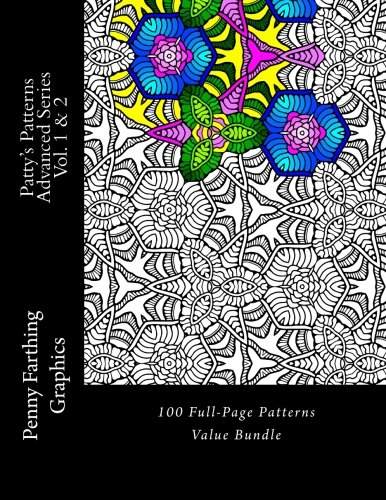

ANSWER: Patty's Patterns - Advanced Series Vol. 1 & 2: 100 Full-Page Patterns Value Bundle


In [4]:
from IPython.display import display

# display a random training example
print('QUESTION:', ds_train.iloc[198]['question'])
display(ds_train.iloc[198]['image'])
print('ANSWER:', ds_train.iloc[198]['answer'])


### Data Preparation

To ensure successful fine-tuning of our model, it’s crucial to properly structure the training data. Correctly formatting the data helps avoid validation errors during training and ensures the model can effectively learn from both text and image inputs. The good news is, this process is quite straightforward.

Each example in the training dataset should be a conversation in the same format as the **Chat Completions API**. Specifically, this means structuring the data as a series of **messages**, where each message includes a `role` (such as "user" or "assistant") and the `content` of the message.

Since we are working with both text and images for vision fine-tuning, we’ll construct these messages to include both content types. For each training sample, the question about the image is presented as a user message, and the corresponding answer is provided as an assistant message.

Images can be included in one of two ways:
* As **HTTP URLs**, referencing the location of the image.
* As **data URLs** containing the image encoded in **base64**.

Here’s an example of how the message format should look:

In [ ]:
{
    "messages": 
    [
        {
            "role": "system",
            "content": "Use the image to answer the question."
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What is the title of this book?"},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,<encoded_image>"}}
            ]
        }
    ]
}

Let's start by defining the **system instructions** for our model. These instructions provide the model with important context, guiding how it should behave when processing the training data. Clear and concise system instructions are particularly useful to make sure the model reasons well on both text and images.

In [5]:
SYSTEM_PROMPT = """
Generate an answer to the question based on the image of the book provided.
Questions will include both open-ended questions and binary "yes/no" questions.
The questions will inquire about the title, author, edition, year and genre of the book in the image.

You will read the question and examine the corresponding image to provide an accurate answer.

# Steps

1. **Read the Question:** Carefully analyze the question to understand what information is being asked.
2. **Examine the Image:**
   - **Identify Relevant Bounding Boxes (if applicable):** For questions requiring specific details like the title or author, focus on the relevant areas or bounding boxes within the image to extract the necessary text. There may be multiple relevant bounding boxes in the image, so be sure to consider all relevant areas.
   - **Analyze the Whole Image:** For questions that need general reasoning (e.g., "Is this book related to Children's Books?"), consider the entire image, including title, graphics, colors, and overall design elements.
3. **Formulate a Reasoned Answer:**
   - For binary questions (yes/no), use evidence from the image to support your answer.
   - For open-ended questions, provide the exact text from the image or a concise phrase that best describes the requested information.

# Output Format

- Provide your answer in a concise and clear manner. Always return the final conclusion only, no additional text or reasoning.
- If the question is binary, answer with "Yes" or "No."
- For open-ended questions requesting specific details (e.g., title, author), return the exact text from the image.
- For questions about general attributes like "genre," return a single word or phrase that best describes it.

# Notes

- Always prioritize accuracy and clarity in your responses.
- If multiple authors are listed, return the first author listed.
- If the information is not present in the image, try to reason about the question using the information you can gather from the image e.g. if the author is not listed, use the title and genre to find the author.
- Ensure reasoning steps logically lead to the conclusions before stating your final answer.

# Examples
You will be provided with examples of questions and corresponding images of book covers, along with the reasoning and conclusion for each example. Use these examples to guide your reasoning process."""

To ensure our images are properly formatted for vision fine-tuning, they must be in **base64 format** and either **RGB or RGBA**. This ensures the model can accurately process the images during training. Below is a function that handles the encoding of images, while also converting them to the correct format if necessary.

This function allows us to control the quality of the image encoding, which can be useful if we want to reduce the size of the file. 100 is the highest quality, and 1 is the lowest. The maximum file size for a fine-tuning job is 1GB, but we are unlikely to see improvements with a very large amount of training data. Nevertheless, we can use the `quality` parameter to reduce the size of the file if needed to accomodate file size limits.

In [6]:
import base64

def encode_image(image, quality=100):
    if image.mode != 'RGB':
        image = image.convert('RGB')  # Convert to RGB
    buffered = BytesIO()
    image.save(buffered, format="JPEG", quality=quality) 
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

We will also include **Few-Shot examples** from the training set as user and assistant messages to help guide the model's reasoning process.


In [7]:
FEW_SHOT_EXAMPLES = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 1:**\n\n**Question:** Who wrote this book?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[286]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Reasoning:** The cover clearly displays two authors' names, 'Evelyn M. Thomson' and 'Orlen N. Johnson,' at the bottom of the cover, with Evelyn M. Thomson listed first. Typically, the first-listed author is considered the primary author or main contributor.\n\n**Conclusion:** Evelyn Thomson"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 2:**\n\n**Question:** What is the title of this book?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[22]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:**\n\n**Reasoning:** The cover prominently displays the title across the top and center of the image. The full title reads, 'Computer Systems: An Integrated Approach to Architecture and Operating Systems,' with each component of the title clearly separated and formatted to stand out.\n\n**Conclusion:** Computer Systems: An Integrated Approach to Architecture and Operating Systems"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 3:**\n\n**Question:** Is this book related to Children's Books?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[492]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:**\n\n**Reasoning:** The cover illustration features a whimsical mermaid holding a red shoe, with gentle, child-friendly artwork that suggests it is targeted toward a young audience. Additionally, the style and imagery are typical of children's literature.\n\n**Conclusion:** Yes"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 4:**\n\n**Question:** Is this book related to History?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[68]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:**\n\n**Reasoning:** The title 'Oliver Wendell Holmes, Jr.: Civil War Soldier, Supreme Court Justice' clearly indicates that this book focuses on the life of Oliver Wendell Holmes, Jr., providing a biographical account rather than a general historical analysis. Although it references historical elements (Civil War, Supreme Court), the primary focus is on the individual rather than historical events as a whole.\n\n**Conclusion:** No"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 5:**\n\n**Question:** What is the genre of this book?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[42]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:**\n\n**Reasoning:** The cover prominently features an image of a train station and the title 'Railway Depots, Stations & Terminals,' which directly suggests a focus on railway infrastructure. This points to the book being related to topics within Engineering & Transportation.\n\n**Conclusion:** Engineering & Transportation"}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "**Example 6:**\n\n**Question:** What type of book is this?"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(ds_train.iloc[334]['image'], quality=50)}"}}
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "**Answer:**\n\n**Reasoning:** The title 'Principles and Practice of Modern Chromatographic Methods' suggests a focus on chromatography, a scientific technique used in chemistry and biology. This aligns with the academic and technical nature typical of books in the 'Science & Math' category.\n\n**Conclusion:** Science & Math"}
        ]
    }
]

Now that we have our system instructions, few-shot examples, and the image encoding function in place, the next step is to iterate through the training set and construct the messages required for fine-tuning. As a reminder, each training example must be formatted as a conversation and must include both the image (in base64 format) and the corresponding question and answer.

To fine-tune GPT-4o, we recommend providing at least **10 examples**, but you’ll typically see noticeable improvements with **50 to 100** training examples. In this case, we'll go all-in and fine-tune the model using our larger training sample of **150 images, and 721 QA pairs**.

In [8]:
from tqdm import tqdm

# constructing the training set
json_data = []

for idx, example in tqdm(ds_train.iterrows()):
    system_message = {
        "role": "system",
        "content": [{"type": "text", "text": SYSTEM_PROMPT}]
    }
    
    user_message = {
        "role": "user",
        "content": [
            {"type": "text", "text": f"Question [{idx}]: {example['question']}"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(example['image'], quality=50)}"}}
        ]
    }
    
    assistant_message = {
        "role": "assistant",
        "content": [{"type": "text", "text": example["answer"]}]
    }

    all_messages = [system_message] + FEW_SHOT_EXAMPLES + [user_message, assistant_message]
    
    json_data.append({"messages": all_messages})

721it [00:01, 518.61it/s]


We save our final training set in a `.jsonl` file where each line in the file represents a single example in the training dataset.

In [235]:
# save the JSON data to a file
with open("ocr-vqa-train.jsonl", "w") as f:
    for message in json_data:
        json.dump(message, f)
        f.write("\n")

Just like the training set, we need to structure our validation and test sets in the same message format. However, for the test set, there's a key difference: since the test set is used for evaluation, we do not include the assistant's message (i.e., the answer). This ensures the model generates its own answers, which we can later compare to the ground truth for performance evaluation.

In [9]:
# constructing the validation set
json_data = []

for idx, example in tqdm(ds_val.iterrows()):
    system_message = {
        "role": "system",
        "content": [{"type": "text", "text": SYSTEM_PROMPT}]
    }
    
    user_message = {
        "role": "user",
        "content": [
            {"type": "text", "text": f"Question [{idx}]: {example['question']}"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(example['image'], quality=50)}"}}
        ]
    }

    assistant_message = {
        "role": "assistant",
        "content": [{"type": "text", "text": example["answer"]}]
    }

    all_messages = [system_message] + FEW_SHOT_EXAMPLES + [user_message, assistant_message]
    
    json_data.append({"messages": all_messages})

# save the JSON data to a file
with open("ocr-vqa-validation.jsonl", "w") as f:
    for message in json_data:
        json.dump(message, f)
        f.write("\n")

239it [00:00, 474.76it/s]


In [10]:
# constructing the test set
json_data = []

for idx, example in tqdm(ds_test.iterrows()):
    system_message = {
        "role": "system",
        "content": [{"type": "text", "text": SYSTEM_PROMPT}]
    }
    
    user_message = {
        "role": "user",
        "content": [
            {"type": "text", "text": f"Question [{idx}]: {example['question']}"},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encode_image(example['image'], quality=50)}"}}
        ]
    }

    all_messages = [system_message] + FEW_SHOT_EXAMPLES + [user_message]
    
    json_data.append({"messages": all_messages})

# save the JSON data to a file
with open("ocr-vqa-test.jsonl", "w") as f:
    for message in json_data:
        json.dump(message, f)
        f.write("\n")

485it [00:00, 490.79it/s]


### Fine-tuning

Now that we have prepared our training and validation datasets in the right format, we can upload them using the [Files API](https://platform.openai.com/docs/api-reference/files/create) for fine-tuning.

In [32]:
# upload training file
train_file = client.files.create(
  file=open("ocr-vqa-train.jsonl", "rb"),
  purpose="fine-tune"
)

# upload validation file
val_file = client.files.create(
  file=open("ocr-vqa-validation.jsonl", "rb"),
  purpose="fine-tune"
)

Once the files are uploaded, we're ready to proceed to the next step: starting the fine-tuning job.

To create a fine-tuning job, we use the fine-tuning API. This may take some time to complete, but you can track the progress of the fine-tuning job in the [Platform UI](https://platform.openai.com/finetune/).

In [33]:
# create fine tuning job
file_train = train_file.id
file_val = val_file.id

client.fine_tuning.jobs.create(
  training_file=file_train,
  # note: validation file is optional
  validation_file=file_val,
  model="gpt-4o-2024-08-06"
)

FineTuningJob(id='ftjob-I1GKWTvusx0900L4ggohrGCP', created_at=1730479789, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-l89177bnhkme4a44292n5r3j', result_files=[], seed=662273734, status='validating_files', trained_tokens=None, training_file='file-UzGnMr4kYPgcFeuq121UBifQ', validation_file='file-LoWiW0fCIa3eirRZExRU3pKB', estimated_finish=None, integrations=[], user_provided_suffix=None, method=None)

### Evaluation

Once the fine-tuning job is complete, it’s time to evaluate the performance of our model by running inference on the test set. This step involves using the fine-tuned model to generate responses to the questions in the test set and comparing its predictions to the ground truth answers for evaluation. We will also run inference on the test set using the non-fine-tuned GPT-4o model for comparison.

In [19]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import re

# load the test data from JSONL file
test_data = []
with open("ocr-vqa-test.jsonl", "r") as f:
    for line in f:
        test_data.append(json.loads(line))

def process_example(example, model):
    response = client.chat.completions.create(
        model=model,
        messages=example["messages"],
        store=True,
        metadata={'dataset': 'ocr-vqa-test'}
    )
    predicted_answer = response.choices[0].message.content.strip()
    
    # regex to get the question ID
    match = re.search(r'\[(\d+)\]', example["messages"][-1]["content"][0]["text"])
    if match:
        example_id = int(match.group(1))
    else:
        example_id = -1
    
    actual_answer = ds_test.iloc[example_id]['answer']

    return {
        "example_id": example_id,
        "predicted_answer": predicted_answer,
        "actual_answer": actual_answer
    }

# run the prompts through the finetuned model and store the results
model = "ft:gpt-4o-2024-08-06:openai::AOY1M8VG"
results = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_example, example, model): example for example in test_data}
    for future in tqdm(as_completed(futures), total=len(futures)):
        results.append(future.result())

# save the results to a file
with open("ocr-vqa-ft-results.jsonl", "w") as f:
    for result in results:
        json.dump(result, f)
        f.write("\n")

# run the prompts through the non-fine-tuned model and store the results
model = "gpt-4o"
results = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_example, example, model): example for example in test_data}
    for future in tqdm(as_completed(futures), total=len(futures)):
        results.append(future.result())

# save the results to a file
with open("ocr-vqa-4o-results.jsonl", "w") as f:
    for result in results:
        json.dump(result, f)
        f.write("\n")

100%|██████████| 485/485 [01:35<00:00,  5.09it/s]


Now that we’ve run inference using our fine-tuned model, let’s inspect a few specific examples to understand how well the model performed compared to the actual answers.

In [ ]:
# Q: What is the title of this book?
{"example_id": 6, "predicted_answer": "A Wrinkle in Time", "actual_answer": "A Wrinkle in Time (Time Quintet)"}
# Q: Who wrote this book?
{"example_id": 10, "predicted_answer": "DK Travel", "actual_answer": "DK Publishing"}
# Q: What is the title of this book?
{"example_id": 11, "predicted_answer": "DK Eyewitness Travel Guide: Peru", "actual_answer": "DK Eyewitness Travel Guide: Peru"}
# Q: What type of book is this?
{"example_id": 12, "predicted_answer": "Travel", "actual_answer": "Travel"}
# Q: Who wrote this book?
{"example_id": 437, "predicted_answer": "Cookshack, Inc.", "actual_answer": "Cookshack"}
# Q: What type of book is this?
{"example_id": 482, "predicted_answer": "Christian Books & Bibles", "actual_answer": "Religion & Spirituality"}

As we can see, the fine-tuned model does a great job at answering the questions, with many responses being exactly correct. 

However, there are also cases where the model’s **predicted answers** are close to the **ground truth**, while not matching exactly, particularly in open-ended questions where phrasing or details may differ. To assess the quality of these predictions, we will use GPT-4o to evaluate the similarity between the predicted responses and the ground truth labels from the dataset.

In order to evaluate our model responses, we will use GPT-4o to determine the similarity between the ground truth and our predicted responses. We will rank our predicted answers based on the following criteria:
* **Very Similar**: The predicted answer exactly matches the ground truth and there is no important information omitted, although there may be some minor ommissions or discrepancies in punctuation.

* **Mostly Similar**: The predicted answer closely aligns with the ground truth, perhaps with some missing words or phrases.

* **Somewhat Similar**: Although the predicted answer has noticeable differences to the ground truth, the core content is accurate and semantically similar, perhaps with some missing information.

* **Incorrect**: The predicted answer is completely incorrect, irrelevant, or contains critical errors or omissions from the ground truth.


In [20]:
from pydantic import BaseModel, Field

# define output schema
class Result(BaseModel):
    example_id: int = Field(description="The unique ID of the question")
    rating: str = Field(description="The assigned similarity rating. One of [Very Similar | Mostly Similar | Somewhat Similar | Incorrect]")
    type: str = Field(description="The type of question. Open if the question is binary yes/no, otherwise Closed. One of [Open | Closed]")

EVAL_PROMPT = """
Evaluate the closeness between the predicted answer and the ground truth for each provided result.
Rank the predicted answer based on the following criteria:

1. **Very Similar**: The predicted answer exactly matches the ground truth and there is no important information omitted, although there may be some minor ommissions or discrepancies in punctuation.
2. **Mostly Similar**: The predicted answer closely aligns with the ground truth, perhaps with some missing words or phrases.
3. **Somewhat Similar**: Although the predicted answer has noticeable differences to the ground truth, the core content is accurate and semantically similar, perhaps with some missing information.
4. **Incorrect**: The predicted answer is completely incorrect, irrelevant, or contains critical errors or omissions from the ground truth.

Ensure to consider both open-ended and yes/no questions.

# Steps
1. **Analyze the Answers**: Read the predicted answer, and ground truth carefully.
2. **Evaluate Similarity**:
    - Check if the predicted answer contains the same core information and correctness as the ground truth.
    - Determine if there are any important omissions or errors.
3. **Assign a Rating**: Based on your evaluation, assign the appropriate rating: Very Similar, Mostly Similar, Somewhat Similar, or Incorrect.

# Output Format
```json
[
    {
        "example_id": [example_id],
        "rating": "[Very Similar | Mostly Similar | Somewhat Similar | Incorrect]",
        "type": "[Open | Closed]
    }
]
```

# Examples

**Input:**
```json
{"example_id": 6, "predicted_answer": "A Wrinkle in Time", "actual_answer": "A Wrinkle in Time (Time Quintet)"}
```
**Reasoning:**
The predicted answer "A Wrinkle in Time" is a very close match to the ground truth "A Wrinkle in Time (Time Quintet)" with a missing tagline or subtitle.
**Output:**
```json
{ "example_id": 6, "rating": "Mostly Similar", "type": "Open" }
```

**Input:**
```json
{"example_id": 437, "predicted_answer": "Cookshack, Inc.", "actual_answer": "Cookshack"}
```
**Reasoning:**
The predicted answer "Cookshack, Inc." is exactly the same as the ground truth "Cookshack", with only a difference in punctuation.
**Output:**
```json
{ "example_id": 437, "rating": "Very Similar", "type": "Open" }
```

**Input:**
```json
{"example_id": 482, "predicted_answer": "Christian Books & Bibles", "actual_answer": "Religion & Spirituality"}
```
**Reasoning:**
The predicted answer "Christian Books & Bibles" is semantically similar to the ground truth "Religion & Spirituality", however there is a key difference in the predicted answer.
**Output:**
```json
{ "example_id": 482, "rating": "Somewhat Similar", "type": "Open" }
```

**Input:**
```json
{ "example_id": 417, "predicted_answer": "yes", "actual_answer": "no" }
```
**Reasoning:**
The predicted answer "yes" is completely incorrect compared to the actual answer "no."
**Output:**
```json
{ "example_id": 417, "rating": "Incorrect", "type": "Closed" }
```
"""

def process_result(result):
    messages = [
        {
            "role": "system",
            "content": EVAL_PROMPT
        },
        {
            "role": "user",
            "content": str(result)
        }
    ]

    response = client.beta.chat.completions.parse(
        model='gpt-4o',
        messages=messages,
        temperature=0,
        response_format=Result
    )

    return json.loads(response.choices[0].message.content)

# fine-tuned model results with scores
results = []
with open("ocr-vqa-ft-results.jsonl", "r") as f:
    for line in f:
        results.append(json.loads(line))

results_w_scores = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_result, result): result for result in results}
    for future in tqdm(as_completed(futures), total=len(futures)):
        results_w_scores.append(future.result())

# Save the results to a file
with open("ocr-vqa-ft-similarity.jsonl", "w") as f:
    for score in results_w_scores:
        json.dump(score, f)
        f.write("\n")

# non-fine-tuned model results with scores
results = []
with open("ocr-vqa-4o-results.jsonl", "r") as f:
    for line in f:
        results.append(json.loads(line))

results_w_scores_4o = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_result, result): result for result in results}
    for future in tqdm(as_completed(futures), total=len(futures)):
        results_w_scores_4o.append(future.result())

# Save the results to a file
with open("ocr-vqa-4o-similarity.jsonl", "w") as f:
    for score in results_w_scores_4o:
        json.dump(score, f)
        f.write("\n")

100%|██████████| 485/485 [00:17<00:00, 27.09it/s]


To fully understand the impact of fine-tuning, we also evaluated the same set of test questions using the **non-fine-tuned GPT-4o** model.

Let's start by comparing the performance of the fine-tuned model vs the non-fine-tuned model for **Closed** form (Yes/No) questions.

Note that with the fine-tuned model, we can check for exact matches between the predicted and actual answers because the model has learned to produce consistent answers that follow the response format specified in the system prompt. However, for the non-fine-tuned model, we need to account for variations in phrasing and wording in the predicted answers. Below is an example of a non-fine-tuned model output. As we can see, the final answer is correct but the response format is inconsistent and outputs reasoning in the response.

In [ ]:
# example of non-fine-tuned model output
{"example_id": 14, "predicted_answer": "**Answer:**\n\nNo. \n\n**Reasoning:** The cover shows \"Eyewitness Travel\" and \"Peru,\" indicating it is a travel guide focused on the country, rather than a pharmaceutical book.", "actual_answer": "No"}

In [21]:
# read in results
results_ft = []
with open("ocr-vqa-ft-results.jsonl", "r") as f:
    for line in f:
        results_ft.append(json.loads(line))

results_4o = []
with open("ocr-vqa-4o-results.jsonl", "r") as f:
    for line in f:
        results_4o.append(json.loads(line))

# filter results for yes/no questions
results_ft_closed = [result for result in results_ft if result['actual_answer'] in ['Yes', 'No']]
results_4o_closed = [result for result in results_4o if result['actual_answer'] in ['Yes', 'No']]

# check for correct predictions
correct_ft_closed = [result for result in results_ft_closed if result['predicted_answer'] == result['actual_answer']]
correct_4o_closed = [
    result for result in results_4o_closed 
    if result['predicted_answer'].lower() == result['actual_answer'].lower() 
    or result['actual_answer'].lower() in result['predicted_answer'].lower()
]
print(f"Fine-tuned model accuracy: {round(100*len(correct_ft_closed) / len(results_ft_closed), 2)}%")
print(f"Non-fine-tuned model accuracy: {round(100*len(correct_4o_closed) / len(results_4o_closed), 2)}%")

Fine-tuned model accuracy: 90.53%
Non-fine-tuned model accuracy: 87.89%


With a generous allowance for variations in phrasing and wording for the non-fine-tuned model including ignoring case and allowing for partial matches, the fine-tuned model still outperforms the non-fine-tuned model by a margin of **2.64%** on this set of questions.

Now, let's compare the performance of the fine-tuned model vs the non-fine-tuned model over all the open-ended questions. First, we'll check for exact matches between the predicted and actual answers, again allowing for general variations in phrasing and wording for the non-fine-tuned model, but maintaining a strict standard for the fine-tuned model.


In [25]:
# filter results for open-ended questions
results_ft_open = [result for result in results_ft if result['actual_answer'] not in ['Yes', 'No']]
results_4o_open = [result for result in results_4o if result['actual_answer'] not in ['Yes', 'No']]

# check for correct predictions
correct_ft_open = [result for result in results_ft_open if result['predicted_answer'] == result['actual_answer']]
correct_4o_open = [
    result for result in results_4o_open 
    if result['predicted_answer'].lower() == result['actual_answer'].lower() 
    or result['actual_answer'].lower() in result['predicted_answer'].lower()
]
print(f"Fine-tuned model accuracy: {round(100*len(correct_ft_open) / len(results_ft_open), 2)}%")
print(f"Non-fine-tuned model accuracy: {round(100*len(correct_4o_open) / len(results_4o_open), 2)}%")

Fine-tuned model accuracy: 64.07%
Non-fine-tuned model accuracy: 46.1%


The improvement in accuracy here is much more pronounced, with the fine-tuned model outperforming the non-fine-tuned model by a substantial margin of **17.97%**, even with very generous allowances for variations in phrasing and wording for the non-fine-tuned model!

If we were to afford the same leniency to the fine-tuned model, we would see an additional 4.1% increase in accuracy, bringing the total margin of improvement to **22.07%**.

To dig a little deeper, we can also look at the accuracy by question type.

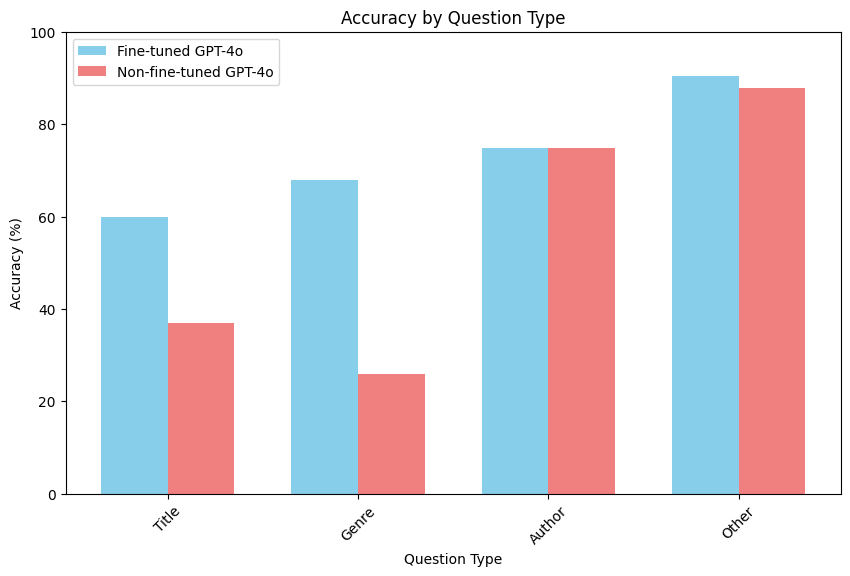

In [26]:
import matplotlib.pyplot as plt

# seperate by question type
def get_question_type(question):
    if question in ["What is the title of this book?"]:
        return "Title"
    elif question in ["What is the genre of this book?", "What type of book is this?"]:
        return "Genre"
    elif question in ["Who wrote this book?", "Who is the author of this book?"]:
        return "Author"
    else:
        return "Other"

# get index numbers for each question type
question_type_indexes = {
    "Title": [],
    "Genre": [],
    "Author": [],
    "Other": []
}

for idx, row in ds_test.iterrows():
    question_type = get_question_type(row['question'])
    question_type_indexes[question_type].append(idx)

# plot accuracy by question type]
accuracy_by_type_ft = {}
accuracy_by_type_4o = {}

for question_type, indexes in question_type_indexes.items():
    correct_predictions_ft = [
        result for result in results_ft if result['example_id'] in indexes and (
            result['predicted_answer'].lower() == result['actual_answer'].lower() or
            result['actual_answer'].lower() in result['predicted_answer'].lower()
        )
    ]
    correct_predictions_4o = [
        result for result in results_4o if result['example_id'] in indexes and (
            result['predicted_answer'].lower() == result['actual_answer'].lower() or
            result['actual_answer'].lower() in result['predicted_answer'].lower()
        )
    ]
    accuracy_ft = len(correct_predictions_ft) / len(indexes) if indexes else 0
    accuracy_4o = len(correct_predictions_4o) / len(indexes) if indexes else 0
    accuracy_by_type_ft[question_type] = accuracy_ft * 100 
    accuracy_by_type_4o[question_type] = accuracy_4o * 100

# prepare data for plotting
question_types = list(accuracy_by_type_ft.keys())
accuracies_ft = list(accuracy_by_type_ft.values())
accuracies_4o = list(accuracy_by_type_4o.values())

# plot grouped bar chart
bar_width = 0.35
index = range(len(question_types))

plt.figure(figsize=(10, 6))
bar1 = plt.bar(index, accuracies_ft, bar_width, label='Fine-tuned GPT-4o', color='skyblue')
bar2 = plt.bar([i + bar_width for i in index], accuracies_4o, bar_width, label='Non-fine-tuned GPT-4o', color='lightcoral')

plt.xlabel('Question Type')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Question Type')
plt.ylim(0, 100)
plt.xticks([i + bar_width / 2 for i in index], question_types, rotation=45)
plt.legend()

plt.show()

It appears that the largest performance gains for the fine-tuned model are for questions in the **Genre** category e.g. "What type of book is this?" or "What is the genre of this book?". This might be indicative of the benefits of fine-tuning in general in that we teach the model to classify genres based on the categories present in the training data. However, it also highlights the model's strong visual undserstanding capabilties, since we are able to identify the genre based on the visual content of the book cover alone.

Additionally, we see significant lift in the **Title** category, which suggests that fine-tuning has boosted the model's OCR capbilities and its ability to understand the layout and structure of the book cover to extract the relevant information.

Finally, let's compare the distribution of similarity ratings between the fine-tuned model and the non-fine-tuned model to allow for variations in phrasing and wording.

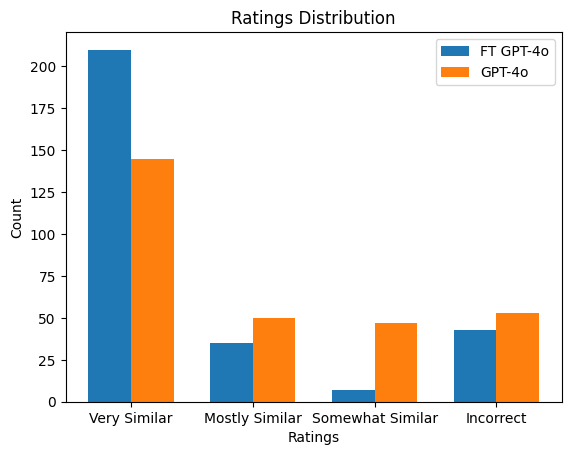

In [27]:
from collections import Counter

# extract ratings
ratings_ft = [result['rating'] for result in results_w_scores if result['type'] == 'Open']
ratings_4o = [result['rating'] for result in results_w_scores_4o if result['type'] == 'Open']

# count occurrences of each rating
rating_counts_ft = Counter(ratings_ft)
rating_counts_4o = Counter(ratings_4o)

# define the order of ratings
rating_order = ["Very Similar", "Mostly Similar", "Somewhat Similar", "Incorrect"]

# create bar chart
bar_width = 0.35
index = range(len(rating_order))

fig, ax = plt.subplots()
bar1 = ax.bar(index, [rating_counts_ft.get(rating, 0) for rating in rating_order], bar_width, label='FT GPT-4o')
bar2 = ax.bar([i + bar_width for i in index], [rating_counts_4o.get(rating, 0) for rating in rating_order], bar_width, label='GPT-4o')

ax.set_xlabel('Ratings')
ax.set_ylabel('Count')
ax.set_title('Ratings Distribution')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(rating_order)
ax.legend()

plt.show()

The results provide a clear picture of the benefits gained through fine-tuning, without any other modifications.
Comparing the distribution of ratings between the **fine-tuned GPT-4o** model and **GPT-4o without fine-tuning**, we see that the fine-tuned model gets many more responses exactly correct, with a comparable amount of incorrect responses.
### Key Takeaways

* **Improved Precision**: Fine-tuning helped the model produce more precise answers that matched the ground truth, especially in highly domain-specific tasks like OCR on book covers.
* **Better Generalization**: While the non-fine-tuned GPT-4o was able to get at least somewhat to the ground truth for many questions, it was less consistent. The fine-tuned model exhibited better generalization across a variety of test questions, thanks to the exposure to multimodal data during training.

While the results from vision fine-tuning are promising, there are still opportunities for improvement. Much like fine-tuning on text, the effectiveness of vision fine-tuning depends heavily on the **quality, diversity, and representativeness** of the training data. In particular, models benefit from focusing on cases where errors occur most frequently, allowing for targeted improvements.

Upon reviewing the incorrect results, many of the "Incorrect" responses from the fine-tuned model are in fact due to inconsistencies in the labels from the dataset. For example, some ground truth answers provide only the first and last name of the author, whereas the image actually shows the middle initial as well. Similarly, some ground truth labels for the title include subheadings and taglines, whereas others do not. 

Another common theme was miscategorization of genres. Although the model was almost always able to produce a semantically similar genre to the ground truth, the answer sometimes deviated. This is likely due to the lack of presence of these genres in the training data. Providing the model with more diverse training examples to cover these genres, or clearer instructions for dealing with edge cases can help to guide the model’s understanding.

### Next Steps:
* **Expand the Training Dataset**: Adding more varied examples that cover the model’s weaker areas, such as identifying genres, could significantly enhance performance.

* **Expert-Informed Prompts**: Incorporating domain-specific instructions into the training prompts may further refine the model’s ability to accurately interpret and respond in complex cases.

Although there is still some progress to be made on this particular task, the initial results are highly encouraging. With minimal setup and effort, we’ve already observed a substantial uplift in overall accuracy with vision fine-tuning, indicating that this approach holds great potential. Vision fine-tuning opens up possibilities for improvement across a wide range of visual question answering tasks, as well as other tasks that rely on strong visual understanding.